## Introduction

In this notebook, a model is trained to make use of the author and movie information provided with each line of dialogue.  Hopefully, by using these features, we can increase the accuracy of our model.

## Imports, Classes, and Constants

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump, load

from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import learning_curve

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.naive_bayes import MultinomialNB

from sklearn import metrics

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

RANDOM_SEED = 42

class StemCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemCountVectorizer, self).build_analyzer()
        
        return lambda document: ([SnowballStemmer('english', ignore_stopwords=True).stem(word) for word in analyzer(document)])

## Data Preprocessing

To make use of the `movie` and `author` features available in the dataset, we can convert them to distinct words and just append them to the end of the `line` feature.

In [2]:
mcu_subset = pd.read_csv("./data/mcu_subset.csv")

np.random.seed(RANDOM_SEED)
mcu_subset = mcu_subset.reindex(np.random.permutation(mcu_subset.index))

mcu_subset['line'] = mcu_subset['line'] + ' ' + mcu_subset['movie'].apply(lambda s: s.upper().replace(" ","").replace(":", "").replace("-","").replace(".",""))
mcu_subset['line'] = mcu_subset['line'] + ' ' + mcu_subset.apply(lambda row: row[row == True].index, axis=1).apply(lambda index: index.to_numpy()).astype(str).apply(lambda s: s.upper().replace(" ", "").replace("-", "").replace("[", "").replace("]","").replace("'", " ").replace("\n", "").replace("WORDS", ""))

mcu_subset.head()



,Unnamed: 0,character,line,movie,year,words,Adam McKay,Anna Boden,Art Marcum,Ashley Edward Miller,...,Joss Whedon,Justin Theroux,Mark Fergus,Matt Holloway,Paul Rudd,Ryan Coogler,Ryan Fleck,Shane Black,Stephen McFeely,Zack Stentz
1263,2218,THOR,"Stay here. Once I have Mjolnir, I will return what they stole from you. Deal? THOR ASHLEYEDWARDMILLER DONPAYNE ZACKSTENTZ",Thor,2011,15,False,False,False,True,...,False,False,False,False,False,False,False,False,False,True
3951,7527,THOR,They'll try to leave the city. AVENGERSAGEOFULTRON JOSSWHEDON,Avengers: Age of Ultron,2015,6,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
4198,8890,TONY STARK,"Oh, yeah. It'd be great if we had a Hulk right about now. Any shot? CAPTAINAMERICACIVILWAR CHRISTOPHERMARKUS STEPHENMCFEELY",Captain America: Civil War,2016,15,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
6078,14843,BRUCE BANNER,It was worse for me. Because I lost twice. First Hulk lost. Then Banner lost. Then we all lost. AVENGERSENDGAME CHRISTOPHERMARKUS STEPHENMCFEELY,Avengers: Endgame,2019,23,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
96,141,TONY STARK,"Okay, here’s what I need... S-Category missiles. Lot 7043. The S-30 explosive tritonal. And a dozen of the S-76. Mortars: M-Category #1, 4, 8, 20, and 60. M- 229’s, I need eleven of these. Mines: the pre-90s AP 5s and AP 16s. IRONMAN ARTMARCUM HAWKOSTBY MARKFERGUS MATTHOLLOWAY",Iron Man,2008,49,False,False,True,False,...,False,False,True,True,False,False,False,False,False,False


In [3]:
pd.DataFrame(mcu_subset['character'].value_counts())

,character
TONY STARK,1788
STEVE ROGERS,977
THOR,863
PETER PARKER,551
NATASHA ROMANOFF,498
PEPPER POTTS,442
BRUCE BANNER,379
NICK FURY,366
LOKI,327
JAMES RHODES,318


In [4]:
y = mcu_subset["character"].to_numpy().astype(str)
X = mcu_subset["line"].to_numpy().astype(str)

X[0:10], y[0:10]

(array(['Stay here. Once I have Mjolnir, I will return what they stole from you. Deal? THOR  ASHLEYEDWARDMILLER  DONPAYNE  ZACKSTENTZ ',
        "They'll try to leave the city. AVENGERSAGEOFULTRON  JOSSWHEDON ",
        "Oh, yeah. It'd be great if we had a Hulk right about now. Any shot? CAPTAINAMERICACIVILWAR  CHRISTOPHERMARKUS  STEPHENMCFEELY ",
        'It was worse for me.  Because I lost twice.  First Hulk lost.  Then Banner lost.  Then we all lost. AVENGERSENDGAME  CHRISTOPHERMARKUS  STEPHENMCFEELY ',
        'Okay, here’s what I need... S-Category missiles.  Lot 7043.  The S-30 explosive tritonal.  And a dozen of the S-76.  Mortars: M-Category #1, 4, 8, 20, and 60.  M- 229’s, I need eleven of these.  Mines: the pre-90s AP 5s and AP 16s.  IRONMAN  ARTMARCUM  HAWKOSTBY  MARKFERGUS  MATTHOLLOWAY ',
        'A little. CAPTAINAMERICATHEFIRSTAVENGER  CHRISTOPHERMARKUS  STEPHENMCFEELY ',
        "You really think I'd need one? My wife kicked me out. CAPTAINAMERICATHEWINTERSOLDIER  CHRI

## Models

In [5]:
cross_validator = StratifiedKFold(n_splits=100, random_state=RANDOM_SEED, shuffle=True)
hyperparameter_cross_validator = StratifiedKFold(n_splits=5, random_state=RANDOM_SEED, shuffle=True)
score_method = "balanced_accuracy"

In [6]:
stem_count_vectorizer = StemCountVectorizer(binary=False)
tfidf_transformer = TfidfTransformer()
nb_classifier = MultinomialNB(alpha=0.01)

In [7]:
count_params = {'vect__stop_words': [None, stopwords.words('english')],
              'vect__ngram_range': [(1,1), (1,2)]}

tfidf_params = {'tfidf__use_idf': [True, False]}

nb_params = {'clf__fit_prior': [True, False]}

In [8]:
pipe15 = Pipeline([('vect', stem_count_vectorizer),
                  ('tfidf', tfidf_transformer),
                  ('clf', nb_classifier)])

parameters15 = {**count_params, **tfidf_params, **nb_params}

model15 = GridSearchCV(pipe15, parameters15, cv=hyperparameter_cross_validator, scoring=score_method, n_jobs=-1, verbose=6)

## Nested CV Balanced Accuracy

In [9]:
models = {"model 15": model15}

cv_score_table = pd.DataFrame()

for name, model in models.items():
    results = cross_val_score(model, X, y, cv=cross_validator, scoring=score_method, n_jobs=-1, verbose=6)
    cv_score_table.insert(len(cv_score_table.columns), name, results, True)

cv_score_table.index.name = "fold"
cv_score_table.loc["mean"] = cv_score_table.mean()
cv_score_table.loc["std"] = cv_score_table.std()
cv_score_table.loc["max"] = cv_score_table.max()

cv_score_table

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed: 168.5min
/usr/local/anaconda3/2020.07/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done  94 out of 100 | elapsed: 453.8min remaining: 29.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 487.6min finished


,model 15
fold,
0,0.481667
1,0.515556
2,0.443889
3,0.407778
4,0.421111
5,0.474444
6,0.401111
7,0.566111
8,0.429444


## Confusion Matrix

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed: 173.9min
/usr/local/anaconda3/2020.07/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done  94 out of 100 | elapsed: 458.8min remaining: 29.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 489.0min finished


Balanced Accuracy: 0.46264694728174566
Balanced Accuracy: 0.46264694728174555


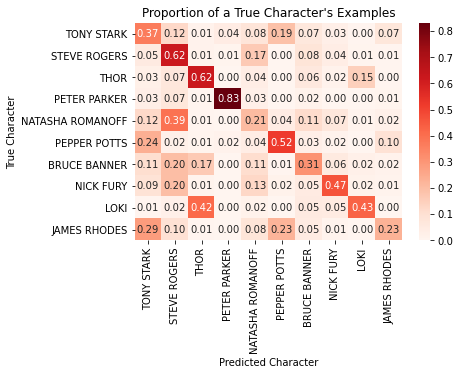

In [10]:
yhat = cross_val_predict(model15, X, y, cv=cross_validator, n_jobs=-1, verbose=6)

main_characters = mcu_subset['character'].value_counts().index.to_numpy()

conf_matrix = pd.DataFrame(metrics.confusion_matrix(y, yhat, labels=main_characters))
normalized_conf_matrix = conf_matrix.div(conf_matrix.sum(axis=1), axis=0)
normalized_conf_matrix.columns = pd.Series(main_characters, name="Predicted Character")
normalized_conf_matrix.index = pd.Series(main_characters, name="True Character")

plt.title("Proportion of a True Character's Examples")
sns.heatmap(normalized_conf_matrix, annot=True, fmt='.2f', cmap=plt.cm.Reds)

# Should be the same
print("Balanced Accuracy:", metrics.balanced_accuracy_score(y,yhat))
print("Balanced Accuracy:", np.mean(np.diagonal(normalized_conf_matrix)))

## Recalls

In [11]:
recalls = pd.DataFrame(np.diagonal(normalized_conf_matrix.to_numpy()), index=main_characters, columns=["recall"])
recalls.sort_values(by="recall", ascending=False, inplace=True)
recalls.loc['mean'] = recalls.mean()

recalls

,recall
PETER PARKER,0.831216
THOR,0.624565
STEVE ROGERS,0.620266
PEPPER POTTS,0.522624
NICK FURY,0.469945
LOKI,0.431193
TONY STARK,0.369128
BRUCE BANNER,0.313984
JAMES RHODES,0.232704
NATASHA ROMANOFF,0.210843


## Conclusion

It seems that by including movie and author indicators as features, we can have much better performance!  Compared to the current production model, including these features allows us to increase balanced accuracy from 29% to 46%!

This won't be used on the front end because it has less to do with the goal of the project, which was to predict a character given dialogue only.